# Querying the trained model

### Yes this is full of print statements, but seemed nice to preserve the literal code used to query the model. Took a matter of hours to get through all of them, and that's including rest to avoid rate limit issues

In [43]:
import subprocess
import os
import json
import base64
import numpy as np
import cv2
from matplotlib import pyplot as plt
from io import BytesIO
from PIL import Image
import time

def segment_image_subprocess(image_path,output_path, api_key):
    # construct url for the roboflow api request
    url = f"https://segment.roboflow.com/monarda_fistulosa_segmentation/1?api_key={api_key}"
    
    # do curl command to query
    # -s flag to suppresses curl's progress thing
    command = f'base64 -i "{image_path}" | curl -s -d @- "{url}"'
    
    try:
        # in troublshooting i used the executable param
        # might not need it any more but doesn't hurt
        output = subprocess.check_output(
            command, shell=True, stderr=subprocess.STDOUT, 
            universal_newlines=True, executable='/bin/bash'
        )
    except subprocess.CalledProcessError as e:
        print("Error occurred while running the command:")
        print(e.output)
        return
    
    try:
        result = json.loads(output)
    except json.JSONDecodeError:
        print("Failed to decode JSON. Raw output:")
        print(output)
        return

    # write out the json response from roboflow
    with open(output_path, "w") as f:
        json.dump(result, f, indent=4)

    print(f"Segmentation result saved to {output_path}")
    
api_key = "api-key-here"  # replace with actual api key

### Demonstrate on one image

In [5]:
image_path = "/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/9.jpg"
base_name = os.path.basename(image_path)
base_name_no_ext = os.path.splitext(base_name)[0]
output_path = os.path.join('/Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results',f"{base_name_no_ext}.json")

In [6]:
segment_image_subprocess(image_path, output_path, api_key)

/Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/9.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/9.json


In [7]:
with open(output_path, "r") as json_file:
    data = json.load(json_file)

Unique pixel values in mask: [0 1]
Resized mask shape: (1536, 2048)


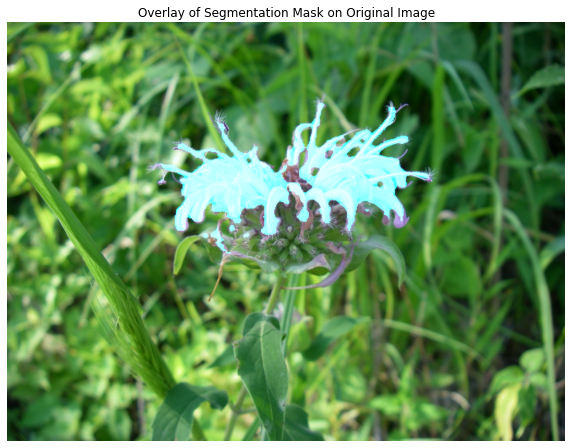

In [10]:
# the base64 segmentation mask 
seg_mask_base64 = data['segmentation_mask']

# decode
mask_data = base64.b64decode(seg_mask_base64)
mask_image = Image.open(BytesIO(mask_data))
mask_np = np.array(mask_image)
print("Unique pixel values in mask:", np.unique(mask_np))  # should be 0 or 1

# read image
orig_img = cv2.imread(image_path)
orig_img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

# resize segmentation mask to match image dims
mask_resized = cv2.resize(mask_np, (orig_img_rgb.shape[1], orig_img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)
print("Resized mask shape:", mask_resized.shape)  # Should match orig_img_rgb dimensions

# just to visualize - make a colored overlay for the mask
alpha = 1  # transparency
colored_mask = np.zeros_like(orig_img_rgb)
colored_mask[mask_resized == 1] = [1, 251, 251]  # color 'flower' pixels

# overlay the mask on the original image with cv2
overlay = cv2.addWeighted(orig_img_rgb, 1, colored_mask, alpha, 0)

# let's see it
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.title("Overlay of Segmentation Mask on Original Image")
plt.axis("off")
plt.show()

### Demonstrate on 100 images, calculate cost in credits.

#### Starting deploy cost: 0.05

In [15]:
first_100 = os.listdir("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/")[:100]

In [19]:
for imfile in first_100:
    image_path = os.path.join("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/",imfile)
    base_name = os.path.basename(image_path)
    base_name_no_ext = os.path.splitext(base_name)[0]
    output_path = os.path.join('/Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results',f"{base_name_no_ext}.json")
    
    segment_image_subprocess(image_path, output_path, api_key)
    
    time.sleep(0.5)

Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/0.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/2.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/4.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/7.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/9.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/10.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/11.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/16.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/17.json
Segmentation re

#### Cost after 101 calls (I accidentally ran one post-0.05 check): 0.15

### An additional 1400 (up to 1500 total):

In [20]:
interval_100_1500 = os.listdir("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/")[100:1500]

In [ ]:
for imfile in interval_100_1500:
    image_path = os.path.join("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/",imfile)
    base_name = os.path.basename(image_path)
    base_name_no_ext = os.path.splitext(base_name)[0]
    output_path = os.path.join('/Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results',f"{base_name_no_ext}.json")
    
    segment_image_subprocess(image_path, output_path, api_key)
    
    time.sleep(0.5)

### 1.39 credits used for deployment.

# Run up to 5000

In [24]:
interval_1500_5000 = os.listdir("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/")[1500:5000]

In [26]:
for imfile in interval_1500_5000:
    image_path = os.path.join("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/",imfile)
    base_name = os.path.basename(image_path)
    base_name_no_ext = os.path.splitext(base_name)[0]
    output_path = os.path.join('/Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results',f"{base_name_no_ext}.json")
    
    segment_image_subprocess(image_path, output_path, api_key)
    
    time.sleep(0.2)

### 4.72 credits used total.

## Run up to 7000

In [27]:
interval_5000_7000 = os.listdir("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/")[5000:7000]

In [28]:
for imfile in interval_5000_7000:
    image_path = os.path.join("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/",imfile)
    base_name = os.path.basename(image_path)
    base_name_no_ext = os.path.splitext(base_name)[0]
    output_path = os.path.join('/Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results',f"{base_name_no_ext}.json")
    
    segment_image_subprocess(image_path, output_path, api_key)
    
    time.sleep(0.2)

Error occurred while running the command:



### 6.84 credits used total

(Now, combined with training and dataset cost, almost up to the 15 free credits per month)

In [41]:
len(os.listdir("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/"))

20765

### Run the rest

In [42]:
interval_7000_end = os.listdir("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/")[7000:]

In [44]:
for imfile in interval_7000_end:
    image_path = os.path.join("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/",imfile)
    base_name = os.path.basename(image_path)
    base_name_no_ext = os.path.splitext(base_name)[0]
    output_path = os.path.join('/Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results',f"{base_name_no_ext}.json")
    
    segment_image_subprocess(image_path, output_path, api_key)
    
    time.sleep(0.2)

Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/14619.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/14620.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/14622.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/14623.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/14626.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/14627.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/14628.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/14629.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_re

KeyboardInterrupt: 

### had to stop it prematurely to relocate -- will restart where I left off when I get back to wifi (10470 of 13765 for this final batch)

In [52]:
len(interval_7000_end)

13765

In [45]:
imfile

'34524.jpg'

In [50]:
np.where(np.array(interval_7000_end) == imfile)

(array([10470]),)

In [51]:
interval_7000_end[10470]

'34524.jpg'

In [53]:
for imfile in interval_7000_end[10470:]:
    image_path = os.path.join("/Volumes/My Passport/monarda_fistulosa_segmentation/image_dataset/gpt_filtered_images/",imfile)
    base_name = os.path.basename(image_path)
    base_name_no_ext = os.path.splitext(base_name)[0]
    output_path = os.path.join('/Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results',f"{base_name_no_ext}.json")
    
    segment_image_subprocess(image_path, output_path, api_key)
    
    time.sleep(0.1)

Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/34524.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/34527.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/34528.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/34529.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/34530.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/34531.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/34532.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_results/34533.json
Segmentation result saved to /Volumes/My Passport/monarda_fistulosa_segmentation/segmentation_re